Cora Graph Classification with Graph Laplacian Features
======================================================
This script demonstrates how to enhance node classification on the Cora citation network
by combining traditional features with spectral embeddings from the graph Laplacian.

Graph-Based Machine Learning with the Cora Citation Network
=========================================================
This notebook demonstrates how to use graph spectral embeddings to improve
node classification on citation networks using the Cora dataset.




## 1. Setup and Imports

 First, let's import all the libraries we'll need and set up our configuration.

In [15]:
!pip install ipywidgets

# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress bars in notebook
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from torch_geometric.datasets import Planetoid  # For loading the Cora dataset
from scipy.sparse.linalg import eigsh  # For eigendecomposition

In [4]:
# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure paths and parameters
DATA_ROOT = './data'  # Where to store the dataset
TRAIN_SIZE = 0.5      # 50% of data for training
VAL_SIZE = 0.3        # 30% of data for validation
TEST_SIZE = 0.2       # 20% of data for testing (implicitly determined)

# Dimensions to test for spectral embeddings
CANDIDATE_DIMENSIONS = [2, 3, 4, 5, 10, 15]

## 2. Loading and Exploring the Cora Dataset

 The Cora dataset is a collection of scientific publications connected by citation links.
 Each paper has:
 - Text features (represented as a bag of words)
 - A category label (research area)
 - Citation links to other papers


In [5]:
# Load the Cora dataset
print("📚 Loading Cora citation network dataset...")
dataset = Planetoid(root=DATA_ROOT, name='Cora')
data = dataset[0]  # Get the first graph (Cora has only one graph)

# Extract important components and convert to numpy for easier handling
edge_index = data.edge_index.numpy()  # Connections between papers
features = data.x.numpy()             # Paper text features (bag of words)
labels = data.y.numpy()               # Paper category labels

# Print dataset summary
print("\n📊 Dataset Summary:")
print(f"  • Number of papers (nodes): {data.num_nodes}")
print(f"  • Number of citations (edges): {edge_index.shape[1]}")
print(f"  • Number of text features per paper: {features.shape[1]}")
print(f"  • Number of paper categories: {len(np.unique(labels))}")

# Display class distribution
class_counts = np.bincount(labels)
print("\n📈 Category Distribution:")
for i, count in enumerate(class_counts):
    print(f"  • Category {i}: {count} papers ({count/len(labels)*100:.1f}%)")

📚 Loading Cora citation network dataset...

📊 Dataset Summary:
  • Number of papers (nodes): 2708
  • Number of citations (edges): 10556
  • Number of text features per paper: 1433
  • Number of paper categories: 7

📈 Category Distribution:
  • Category 0: 351 papers (13.0%)
  • Category 1: 217 papers (8.0%)
  • Category 2: 418 papers (15.4%)
  • Category 3: 818 papers (30.2%)
  • Category 4: 426 papers (15.7%)
  • Category 5: 298 papers (11.0%)
  • Category 6: 180 papers (6.6%)


## 3. Building the Graph

 Now we'll convert the data into a NetworkX graph structure and visualize a sample
 of the network to get a better understanding of what we're working with.

In [7]:
# Create a NetworkX graph from the edge index
print("\n🔄 Converting data to NetworkX graph format...")

# Create an empty graph
G = nx.Graph()

# Add all nodes (papers) to ensure isolated papers are included
G.add_nodes_from(range(np.max(edge_index) + 1))

# Add all edges (citations)
G.add_edges_from(edge_index.T)

print(f"  • Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"  • Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")


🔄 Converting data to NetworkX graph format...
  • Graph built with 2708 nodes and 5278 edges
  • Average degree: 3.90




Let's visualize a sample of the graph to see the network structure:

/var/folders/9c/dr5hpt0574183ypmcv_q0jl80000gr/T/ipykernel_99545/4016346300.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


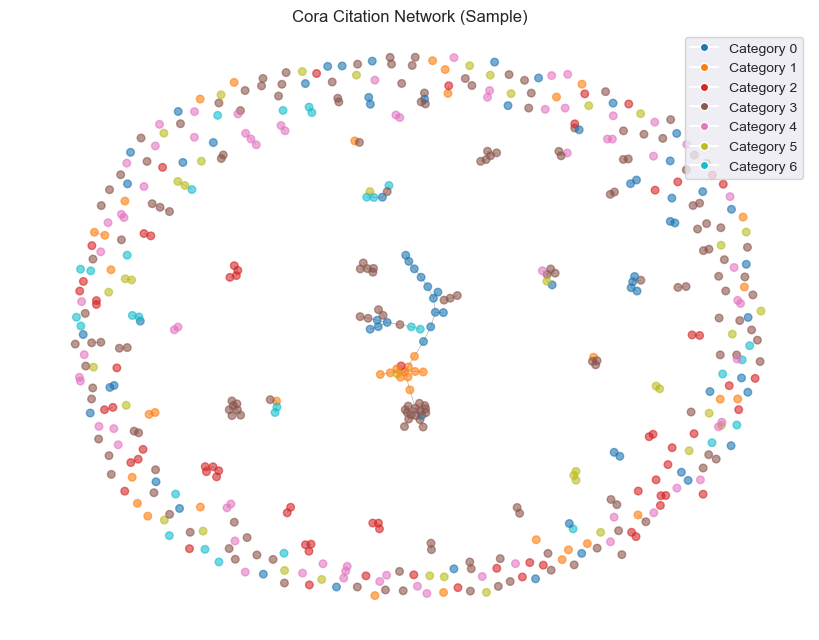

In [8]:
# Create a visualization of a subset of the graph
plt.figure(figsize=(8, 6))

# Get a sample of nodes for visualization
sampled_nodes = np.random.choice(G.nodes(), min(500, G.number_of_nodes()), replace=False)
subgraph = G.subgraph(sampled_nodes)

# Get unique classes for color mapping
unique_classes = np.unique(labels)
color_map = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

# Color nodes by their category
node_colors = [color_map[labels[node]] for node in subgraph.nodes()]

# Draw the graph
pos = nx.spring_layout(subgraph, seed=RANDOM_SEED)
nx.draw(subgraph, pos, node_color=node_colors, node_size=30,
        edge_color='gray', alpha=0.6, width=0.5)

# Add a legend
class_handles = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color_map[i],
                            label=f'Category {i}')
                 for i in unique_classes]
plt.legend(handles=class_handles, loc='upper right')

plt.title("Cora Citation Network (Sample)")
plt.tight_layout()
plt.show()

## 4. Spectral Graph Analysis

 We'll now compute the normalized Laplacian matrix of the graph and its
 eigendecomposition. This gives us spectral embeddings that capture the
 structural properties of the graph.

 Think of the Laplacian eigenvectors as "natural modes of vibration" of the
 graph - they reveal how information flows through the network.


In [9]:
print("\n🧮 Computing graph spectral embeddings...")

# Compute the normalized Laplacian matrix
# This is L = I - D^(-1/2)AD^(-1/2) where A is adjacency and D is degree matrix
print("\n  • Computing normalized Laplacian matrix...")
L = nx.normalized_laplacian_matrix(G)

print("  • Finding the eigenvalues and eigenvectors...")
# We use the sparse eigensolver for efficiency with large graphs
# 'SM' means smallest magnitude eigenvalues
max_dim = max(CANDIDATE_DIMENSIONS) + 1
eigvals, eigvecs = eigsh(L, k=max_dim+1, which='SM')

# Sort by eigenvalues (should already be sorted by eigsh, but just to be safe)
idx = eigvals.argsort()
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print(f"  • Computed {len(eigvals)} eigenvalues/eigenvectors")


🧮 Computing graph spectral embeddings...

  • Computing normalized Laplacian matrix...
  • Finding the eigenvalues and eigenvectors...
  • Computed 17 eigenvalues/eigenvectors


## 5. Creating Data Splits

 We'll split our data into training, validation, and test sets:
 - Training set (50%): Used to train the model
 - Validation set (30%): Used to select the best embedding dimension
 - Test set (20%): Used for final evaluation

In [11]:
print("\n✂️ Creating train/validation/test splits...")

# Create an array of all node indices
indices = np.arange(data.num_nodes)

# Shuffle the indices
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)

# Calculate split sizes
train_count = int(TRAIN_SIZE * data.num_nodes)
val_count = int(VAL_SIZE * data.num_nodes)

# Split the indices
train_idx = indices[:train_count]
val_idx = indices[train_count:train_count+val_count]
test_idx = indices[train_count+val_count:]

# Print split information
print(f"  • Training set: {len(train_idx)} nodes ({TRAIN_SIZE*100:.0f}%)")
print(f"  • Validation set: {len(val_idx)} nodes ({VAL_SIZE*100:.0f}%)")
print(f"  • Test set: {len(test_idx)} nodes ({TEST_SIZE*100:.0f}%)")


✂️ Creating train/validation/test splits...
  • Training set: 1354 nodes (50%)
  • Validation set: 812 nodes (30%)
  • Test set: 542 nodes (20%)


## 6. Finding the Optimal Embedding Dimension

 Now we'll try different dimensions for the Laplacian embeddings to find
 the optimal number of dimensions to use. For each dimension:

 1. Extract the corresponding eigenvectors
 2. Combine them with the original features
 3. Train an XGBoost classifier
 4. Evaluate on the validation set

In [16]:
print("\n🔍 Finding the optimal spectral embedding dimension...")
print("  • We'll combine the original features with different numbers of")
print("    spectral embedding dimensions and see which works best")

best_d = None
best_val_score = -np.inf
best_enriched_features = None
results = []

# Try each candidate dimension
for d in tqdm(CANDIDATE_DIMENSIONS):
    # Use eigenvectors 1 to d+1 (skip the trivial eigenvector 0)
    # The first eigenvector (index 0) is constant and uninformative
    lap_embedding = eigvecs[:, 1:1+d]

    # Combine with original features
    # This enriches the text features with graph structural information
    features_enriched = np.concatenate([features, lap_embedding], axis=1)

    # Train a classifier
    clf = XGBClassifier(
        max_depth=2,              # Simple model to avoid overfitting
        random_state=RANDOM_SEED,
        use_label_encoder=False,
        eval_metric='mlogloss',
        verbosity=0               # Suppress XGBoost messages
    )

    # Train on the training set
    clf.fit(features_enriched[train_idx], labels[train_idx])

    # Evaluate on the validation set
    preds_val = clf.predict(features_enriched[val_idx])
    val_score = precision_score(
        labels[val_idx],
        preds_val,
        average='macro',          # Equal weight to all classes
        zero_division=0
    )

    print(f"  • Dimension d={d}: Validation Macro Precision = {val_score:.4f}")
    results.append((d, val_score))

    # Save the best performing model
    if val_score > best_val_score:
        best_val_score = val_score
        best_d = d
        best_enriched_features = features_enriched.copy()

print(f"\n✅ Best spectral embedding dimension: d={best_d}")
print(f"  • Validation score: {best_val_score:.4f}")


🔍 Finding the optimal spectral embedding dimension...
  • We'll combine the original features with different numbers of
    spectral embedding dimensions and see which works best




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.89it/s]

  • Dimension d=2: Validation Macro Precision = 0.7435




 33%|███▎      | 2/6 [00:01<00:02,  1.93it/s]

  • Dimension d=3: Validation Macro Precision = 0.7442




 50%|█████     | 3/6 [00:01<00:01,  1.96it/s]

  • Dimension d=4: Validation Macro Precision = 0.7404




 67%|██████▋   | 4/6 [00:02<00:01,  1.95it/s]

  • Dimension d=5: Validation Macro Precision = 0.7408




 83%|████████▎ | 5/6 [00:02<00:00,  1.91it/s]

  • Dimension d=10: Validation Macro Precision = 0.7552




100%|██████████| 6/6 [00:03<00:00,  1.89it/s]

  • Dimension d=15: Validation Macro Precision = 0.7854

✅ Best spectral embedding dimension: d=15
  • Validation score: 0.7854


 Let's visualize how the different embedding dimensions performed:


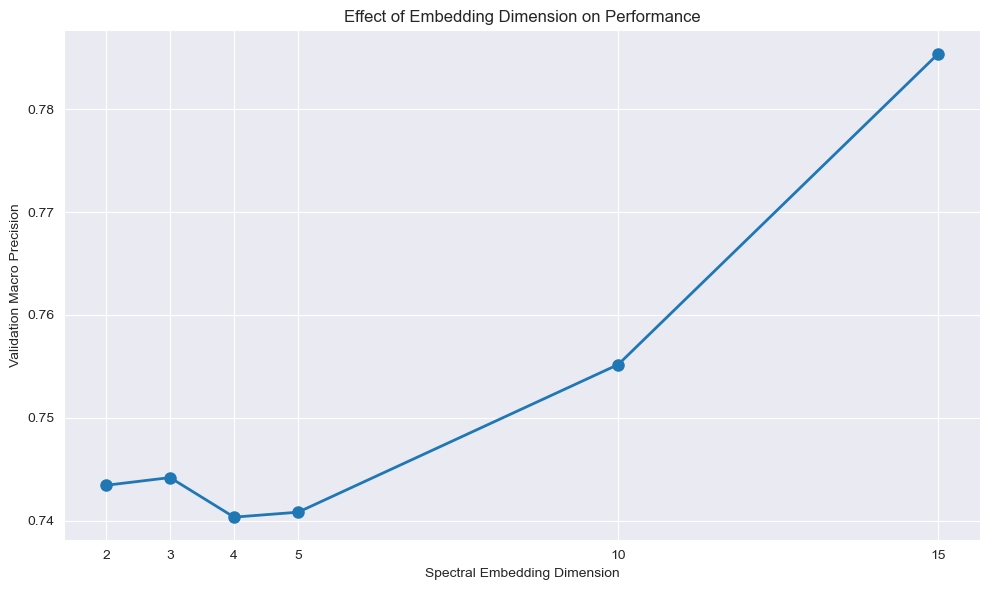

In [17]:
# Plot the validation results
plt.figure(figsize=(10, 6))
dims, scores = zip(*results)
plt.plot(dims, scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Spectral Embedding Dimension')
plt.ylabel('Validation Macro Precision')
plt.title('Effect of Embedding Dimension on Performance')
plt.grid(True)
plt.xticks(dims)
plt.tight_layout()
plt.show()

7. Training the Final Model

 Now that we've found the best embedding dimension, we'll train our final model
 using both the training and validation sets, and evaluate on the test set.

In [18]:
print("\n🧠 Training the final classification model...")

# Combine training and validation sets for the final model
train_val_idx = np.concatenate([train_idx, val_idx])

# Initialize the final classifier
clf_final = XGBClassifier(
    max_depth=2,
    random_state=RANDOM_SEED,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train on combined train+validation data
clf_final.fit(best_enriched_features[train_val_idx], labels[train_val_idx])

print("\n📊 Evaluating on test data...")

# Make predictions on all nodes (we'll use the test set for evaluation)
predicted_labels = clf_final.predict(best_enriched_features)

# Calculate test precision
test_precision = precision_score(
    labels[test_idx],
    predicted_labels[test_idx],
    average='macro',
    zero_division=0
)

print(f"\n📈 Test Macro Precision: {test_precision:.4f}")


🧠 Training the final classification model...


/Users/victormpreciado/anaconda3/envs/torchgeo/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:20:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1742444258230/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Evaluating on test data...

📈 Test Macro Precision: 0.8657


 Let's look at the detailed classification report to see how well our model
 performs on each category:

In [19]:
# Print detailed classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(labels[test_idx], predicted_labels[test_idx]))


📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        71
           1       0.92      0.80      0.85        44
           2       0.94      0.94      0.94        81
           3       0.80      0.95      0.87       150
           4       0.94      0.85      0.89        91
           5       0.82      0.82      0.82        67
           6       0.80      0.74      0.77        38

    accuracy                           0.86       542
   macro avg       0.87      0.83      0.85       542
weighted avg       0.86      0.86      0.86       542



### 🔍 Classification Report Summary

- **Overall Accuracy**: 86% — strong overall performance on the test set.

- **Class-wise Observations**:
  - **Class 2**: Excellent performance (Precision & Recall = 0.94).
  - **Class 3**: Very high recall (0.95), but lower precision (0.80) → many predictions fall into this class.
  - **Class 6**: Slightly lower recall (0.74) → some true instances are missed.

- **Macro Avg** (unweighted mean across classes):
  - Precision = 0.87, Recall = 0.83 → good performance across all classes, even those with fewer samples.

- **Weighted Avg** (accounts for class imbalance):
  - Precision/Recall/F1 ≈ 0.86 → stable and reliable performance overall.

✅ The classifier performs well and handles class imbalance reasonably, with strongest results on balanced or well-represented classes.

 And create a confusion matrix to visualize the classification results:

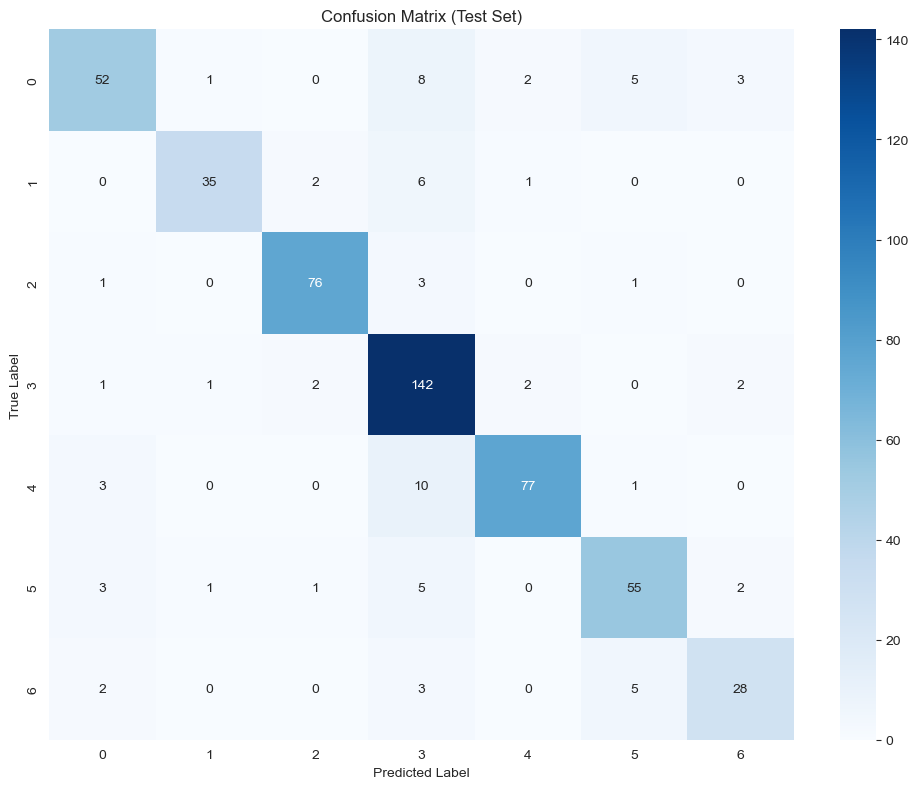

In [20]:
# Create confusion matrix
cm = confusion_matrix(labels[test_idx], predicted_labels[test_idx])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(len(np.unique(labels))),
            yticklabels=range(len(np.unique(labels))))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

## 8. Visualizing Results on the Graph

 Finally, let's visualize the true and predicted labels on a sample of the graph:



🎨 Creating graph visualizations...


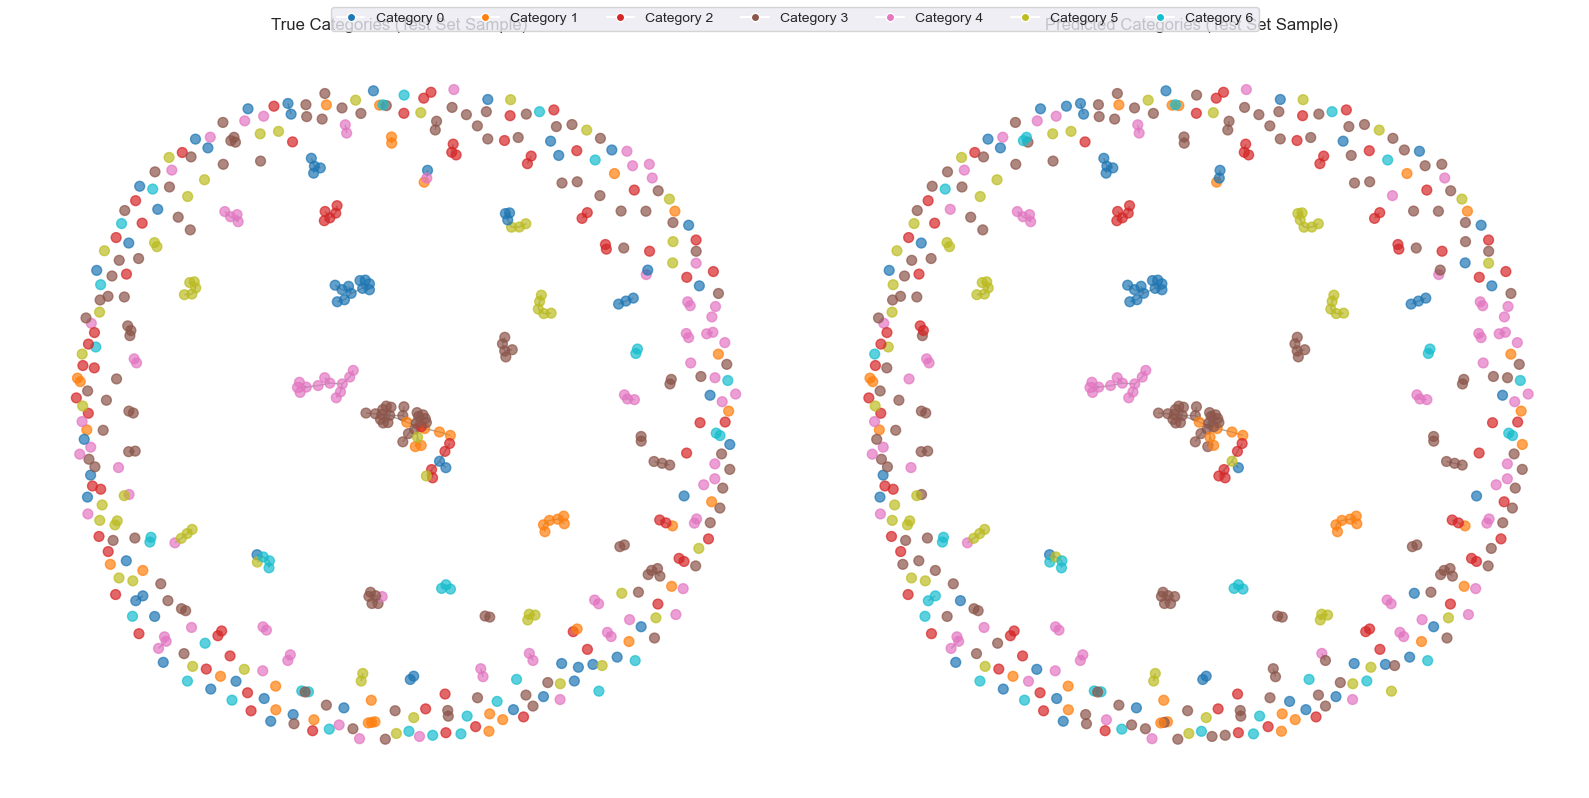

In [21]:
print("\n🎨 Creating graph visualizations...")

# Get unique classes for color mapping
unique_classes = np.unique(labels)
color_map = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

# Sample nodes from test set for better visualization
sample_size = min(500, G.number_of_nodes())
sampled_nodes = np.random.choice(test_idx, min(sample_size, len(test_idx)), replace=False)
test_subgraph = G.subgraph(sampled_nodes)

# Get positions for node layout (consistent across plots)
pos = nx.spring_layout(test_subgraph, seed=RANDOM_SEED)

# Create a side-by-side comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Map each node to its corresponding color
true_colors = [color_map[labels[i]] for i in test_subgraph.nodes()]
pred_colors = [color_map[predicted_labels[i]] for i in test_subgraph.nodes()]

# Plot true labels
nx.draw(test_subgraph, pos, node_color=true_colors,
        node_size=50, ax=ax1, edge_color='gray', alpha=0.7)
ax1.set_title("True Categories (Test Set Sample)")

# Plot predicted labels
nx.draw(test_subgraph, pos, node_color=pred_colors,
        node_size=50, ax=ax2, edge_color='gray', alpha=0.7)
ax2.set_title("Predicted Categories (Test Set Sample)")

# Add class legend
class_handles = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color_map[i],
                            label=f'Category {i}')
                 for i in unique_classes]
fig.legend(handles=class_handles, loc='upper center', ncol=len(unique_classes))

plt.tight_layout()
plt.show()


## 10. Conclusion

 In this notebook, we've demonstrated how to:

 1. **Load and explore** the Cora citation network dataset
 2. **Build a graph representation** of the citation network
 3. **Compute spectral embeddings** using the graph Laplacian
 4. **Find the optimal embedding dimension** through cross-validation
 5. **Train and evaluate** a classifier using both text features and graph structure
 6. **Visualize the results** to understand model performance

 Key takeaways:

 - Combining node features with graph structure improves classification performance
 - Spectral embeddings capture how information flows in the citation network
 - The best dimension balances complexity and information content
 - This approach leverages both text content and network context